# Kaggle: Plant Pathology 2021 - FGVC8

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Borda/kaggle_plant-pathology/blob/main/notebooks/Plant-Pathology-with-Flash.ipynb)

## Setup environment 

- connect the gDrive with dataset
- extract data to local
- install pytorch lightning

In [1]:
from google.colab import drive
# connect to  my gDrive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# copy the dataset to local drive
! rsync -ah --progress /content/gdrive/Shareddrives/Datasets/plant-pathology-2021-fgvc8_640.zip plant-pathology-2021-fgvc8.zip

sending incremental file list
plant-pathology-2021-fgvc8_640.zip
        683.08M 100%  122.31MB/s    0:00:05 (xfr#1, to-chk=0/1)


In [3]:
# extract dataset to the drive
! unzip plant-pathology-2021-fgvc8.zip | awk 'BEGIN {ORS=" "} {if(NR%250==0)print "."}'
! ls -l

replace train_images/f0cbf4487fcae480.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . total 668444
drwxr-xr-x 4 root root      4096 Apr  3 16:54 dataset
drwx------ 6 root root      4096 Apr  3 16:51 gdrive
drwxr-xr-x 3 root root      4096 Apr  3 16:54 lightning_logs
-rw------- 1 root root 683082495 Apr  3 08:45 plant-pathology-2021-fgvc8.zip
drwxr-xr-x 1 root root      4096 Mar 25 13:38 sample_data
-rw-r--r-- 1 root root       100 Mar 11 21:00 sample_submission.csv
drwxr-xr-x 2 root root      4096 Apr  3 16:59 test_images
-rw-r--r-- 1 root root    608503 Mar 11 21:00 train.csv
drwxr-xr-x 2 root root    761856 Apr  3 16:59 train_images


In [4]:
! pip install -q "lightning-bolts==0.3.2" "torchtext==0.6"
! pip install -q "lightning-flash==0.2.2rc2"
! pip list | grep torch
! pip list | grep lightning

ERROR: lightning-flash 0.2.2rc2 has requirement lightning-bolts==0.3.2rc1, but you'll have lightning-bolts 0.3.2 which is incompatible.
pytorch-lightning             1.2.0rc0      
pytorch-tabnet                3.1.0         
torch                         1.8.1+cu101   
torchmetrics                  0.2.0         
torchsummary                  1.5.1         
torchtext                     0.6.0         
torchvision                   0.9.1+cu101   
lightning-bolts               0.3.2rc1      
lightning-flash               0.2.2rc2      
pytorch-lightning             1.2.0rc0      


In [5]:
! nvidia-smi

Sat Apr  3 16:59:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data exploration

Checking what data do we have available and what is the labels distribution...

Looking in the training dataset table, what colums and what is the data representation...

In [6]:
%matplotlib inline

import os
import json
import pandas as pd
from pprint import pprint

base_path = '/content'
path_csv = os.path.join(base_path, 'train.csv')
train_data = pd.read_csv(path_csv)
print(train_data.head())

                  image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex


We can see that each image can have multiple labels so lets check what is the mos common label count...

*The target classes, a space delimited list of all diseases found in the image.
Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.*

In [7]:
import numpy as np

train_data['nb_classes'] = [len(lbs.split(" ")) for lbs in train_data['labels']]
lb_hist = dict(zip(range(10), np.bincount(train_data['nb_classes'])))
pprint(lb_hist)

{0: 0, 1: 17277, 2: 1155, 3: 200}


Browse the label distribution, enrolling all labels in the dataset, so in case an image has two labels both are used in this stat...

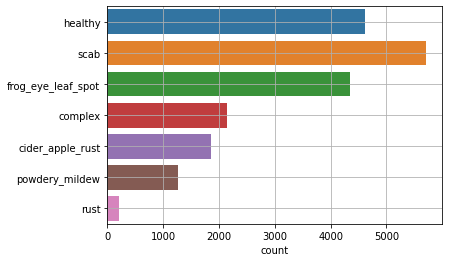

In [8]:
import itertools
import seaborn as sns

labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in train_data['labels']]))
train_data['labels_sorted'] = [" ".join(sorted(lbs.split(" "))) for lbs in train_data['labels']]

ax = sns.countplot(y=labels_all, orient='v')
ax.grid()

## Dataset adjusment

In [9]:
# ! apt-get install -qq -y imagemagick
# #! mogrify -resize 960 train_images/*.jpg

# import os, tqdm, glob
# import multiprocessing

# ls_images = glob.glob("train_images/*.jpg")
# print(f'found images: {len(ls_images)}')

# def _convert(pimg: str):
#     os.system(f'convert -resize 640 point {pimg} {pimg}')

# nb_cpu = multiprocessing.cpu_count()
# pbar = tqdm.tqdm(total=len(ls_images), desc=f"using {nb_cpu} proc.")
# pool = multiprocessing.Pool(processes=nb_cpu)
# for _ in pool.imap(_convert, ls_images):
#     pbar.update()
# pool.close()
# pool.join() 

In [10]:
! rm -rf /content/dataset

import os
import tqdm
import shutil
import pandas as pd

data = pd.read_csv(path_csv)
# shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

frac = int(0.8 * len(data))
train = data[:frac]
valid = data[frac:]
dataset_path = '/content/dataset'

# crating train and valid folder
for folder, df in [('train', train), ('valid', valid)]:
  folder = os.path.join(dataset_path, folder)
  os.makedirs(folder, exist_ok=True)
  # triage images per class / label
  for _, row in tqdm.tqdm(df.iterrows()):
    img_name, lb = row['image'], row['labels']
    if 'complex' in lb or len(lb.split(" ")) > 1:
      lb = 'complex'
    folder_lb = os.path.join(folder, str(lb))
    # create folder for label if it is missing
    if not os.path.isdir(folder_lb):
      os.mkdir(folder_lb)
    shutil.copy(os.path.join(dataset_path, 'train_images', img_name), os.path.join(folder_lb, img_name))

! ls -l /content/dataset/train
! ls -l /content/dataset/valid

14905it [00:04, 3632.57it/s]
3727it [00:01, 3424.52it/s]


total 636
drwxr-xr-x 2 root root  65536 Apr  3 16:59 cider_apple_rust
drwxr-xr-x 2 root root 102400 Apr  3 16:59 complex
drwxr-xr-x 2 root root 106496 Apr  3 16:59 frog_eye_leaf_spot
drwxr-xr-x 2 root root 143360 Apr  3 16:59 healthy
drwxr-xr-x 2 root root  45056 Apr  3 16:59 powdery_mildew
drwxr-xr-x 2 root root 163840 Apr  3 16:59 scab
total 184
drwxr-xr-x 2 root root 20480 Apr  3 16:59 cider_apple_rust
drwxr-xr-x 2 root root 28672 Apr  3 16:59 complex
drwxr-xr-x 2 root root 36864 Apr  3 16:59 frog_eye_leaf_spot
drwxr-xr-x 2 root root 36864 Apr  3 16:59 healthy
drwxr-xr-x 2 root root 12288 Apr  3 16:59 powdery_mildew
drwxr-xr-x 2 root root 36864 Apr  3 16:59 scab


## Flash finetuning

In [11]:
import flash
import torch
import multiprocessing as mproc
from flash.core.data import download_data
from flash.core.finetuning import FreezeUnfreeze
from flash.vision import ImageClassificationData, ImageClassifier

# 2. Load the data
datamodule = ImageClassificationData.from_folders(
    train_folder=os.path.join(dataset_path, "/train/"),
    valid_folder=os.path.join(dataset_path, "/valid/"),
    batch_size=128,
    num_workers=mproc.cpu_count(),
)

# 3. Build the model
model = ImageClassifier(
    backbone="resnet34",
    optimizer=torch.optim.Adam,
    num_classes=datamodule.num_classes,
)

/usr/local/lib/python3.7/dist-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  f' install it with `pip install {pypi_name}`.' + extra_text


In [ ]:
# 4. Create the trainer. Run twice on data
trainer = flash.Trainer(
    gpus=1,
    max_epochs=10,
    precision=16,
    val_check_interval=0.5,
    progress_bar_refresh_rate=1,
)

# 5. Train the model
trainer.finetune(model, datamodule=datamodule, strategy=FreezeUnfreeze(unfreeze_epoch=1))

# 7. Save it!
trainer.save_checkpoint("image_classification_model.pt")

Quick visualization of the training process...

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/